In [7]:
# How I get the 20 news groups dataset
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from matplotlib import pyplot as plt
import Ipynb_importer
from scipy.sparse import save_npz

data = fetch_20newsgroups_vectorized(subset = 'all')


target = data.target
target_names = data.target_names
data = data.data

save_npz('20news', data)

In [ ]:
# import package
import torch
from torch.autograd import Variable
import Ipynb_importer
from deep_nmf import Deep_NMF, Energy_Loss_Func
from writer import Writer

In [2]:
import torch.utils.data
import torch

In [3]:
# The matrix is tooo large if transformed into a torch tensor, so I have to do that in a stochastic way.
# Here I define a dataloader that will take the subset of the sparse numpy matrix and then only transform this subset into
# a torch Tensor, which will save memories

class sparsedata(torch.utils.data.Dataset):
    def __init__(self, data, label,transform = None):
        self.data = data
        self.label = label
        self.transform = transform
        self.len = data.shape[0]
        assert(self.len == len(label))
    def __getitem__(self, index):
        inputs = self.data[index,:]
        if self.transform is not None:
            inputs = self.transform(inputs)
        target = self.label[index]
        inputs = torch.Tensor(inputs.todense()).double()
        if type(index) == int:
            target = torch.Tensor([target])
        else:
            target = torch.Tensor(target)
        return inputs, target
    def __len__(self):
        return self.len

In [43]:
# Setting the dataset and the dataloader
dataset = sparsedata(data*1000, target)

In [51]:
# Defining the network structure
m = data.shape[1]
k1 = 200
k2 = 20
net = Deep_NMF([m,k1, k2])
loss_func = Energy_Loss_Func()

In [45]:
import time

In [52]:
# Training process!

# setting training parameters
epoch = 5
lr = 10000
loss_lst = []
# train!
for epo in range(epoch):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = 50, shuffle = True)
    total_loss = 0
    for (i, (inputs, label)) in enumerate(dataloader):
        t1 = time.time()
        inputs = inputs.view([inputs.shape[0], inputs.shape[2]])
        inputs, label = Variable(inputs), Variable(label)
        S_lst = net(inputs)
        loss = loss_func(net, inputs, S_lst)
        loss.backward()
        print(loss.data)
        loss_lst.append(loss.data)
        t2 = time.time()
        print('time for one step:', t2 -t1)
        total_loss += loss.data
        for A in net.parameters():
            A.data = A.data.sub_(lr*A.grad.data)
            A.data = A.data.clamp(min = 0)
    print('epoch = ', epo, '\n', total_loss)

tensor(7.6802, dtype=torch.float64)
time for one step: 81.9965980052948
tensor(7.6799, dtype=torch.float64)
time for one step: 72.37643885612488
tensor(7.6778, dtype=torch.float64)
time for one step: 50.960200548172
tensor(7.6682, dtype=torch.float64)
time for one step: 18.967193603515625
tensor(7.6366, dtype=torch.float64)
time for one step: 18.136932373046875
tensor(7.5207, dtype=torch.float64)
time for one step: 17.434265851974487
tensor(7.1609, dtype=torch.float64)
time for one step: 17.182661294937134
tensor(6.3933, dtype=torch.float64)
time for one step: 17.37985324859619
tensor(5.6757, dtype=torch.float64)
time for one step: 17.57507872581482
tensor(4.7706, dtype=torch.float64)
time for one step: 17.288352489471436
tensor(5.1873, dtype=torch.float64)
time for one step: 40.88153433799744
tensor(4.6627, dtype=torch.float64)
time for one step: 50.1929771900177
tensor(5.2834, dtype=torch.float64)
time for one step: 49.81332492828369
tensor(5.3434, dtype=torch.float64)
time for one s

tensor(4.4873, dtype=torch.float64)
time for one step: 41.384572982788086
tensor(4.4857, dtype=torch.float64)
time for one step: 41.64253330230713
tensor(4.6225, dtype=torch.float64)
time for one step: 41.52451801300049
tensor(4.3569, dtype=torch.float64)
time for one step: 43.72737431526184
tensor(4.3862, dtype=torch.float64)
time for one step: 42.949196577072144
tensor(4.5029, dtype=torch.float64)
time for one step: 43.387335777282715
tensor(4.6602, dtype=torch.float64)
time for one step: 43.791762590408325
tensor(4.5523, dtype=torch.float64)
time for one step: 44.31623959541321
tensor(4.4601, dtype=torch.float64)
time for one step: 45.21805191040039
tensor(4.4686, dtype=torch.float64)
time for one step: 44.495729207992554
tensor(4.3926, dtype=torch.float64)
time for one step: 45.496755599975586
tensor(4.4780, dtype=torch.float64)
time for one step: 47.26475691795349
tensor(4.4807, dtype=torch.float64)
time for one step: 45.69879484176636
tensor(4.5379, dtype=torch.float64)
time for 

KeyboardInterrupt: 

In [15]:
def get_whole_output(net, dataset, param_lst = None):
    history = Writer()
    # initialize the network with certain initial value
    if param_lst is not None:
        for (i,param) in enumerate(net.parameters()):
            param.data = param_lst[i]
    # start to forward propagate, 100 at a time
    n = len(dataset)
    if n%100 == 0:
        batch_num = n/100
    else:
        batch_num = n//100 + 1
    print('batch_num = ', batch_num, '\n')
    for i in range(batch_num):
        print('current at batch:', i)
        try:
            (inputs, label) = dataset[i*100:(i+1)*100]
        except:
            (inputs, label) = dataset[i*100:]
        history.add_tensor('label', label)
        output = net(inputs)
        history.add_tensor('output', output)
    return history

In [19]:
# use the S matrix as the features for the data and the do linear regression to see how it works out
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import scipy.io as sio

In [54]:
# get the total S matrix and the total label
S_lst = history.get('output')
S_lst = [S_lst[i][0].data for i in range(len(S_lst))]
S = torch.cat(S_lst, dim = 0)
label = history.cat_lst('label')
S = S.numpy()
S_normalized = (S - np.reshape(np.mean(S,1), [-1,1]))/np.reshape(np.std(S,1),[-1,1])
label = label.numpy()
# encode the label
le = LabelEncoder()
le.fit(label)
label = le.transform(label)

In [56]:
# use logistic regression to classify
clf = LogisticRegression()
clf.fit(S_normalized, label)
pred = clf.predict(S_normalized)
np.sum(pred == label)/len(pred)

0.24482648837949697

In [ ]:
for C in [10, 100, 1000]:
    clf = SVC(kernel = 'linear', C = C)
    clf.fit(S_normalized, label)
    pred = clf.predict(S_normalized)
    print('C = ', C)
    print('acc = ', np.sum(pred == label)/len(pred))

C =  10
acc =  0.24992040751353073
C =  100
acc =  0.2502387774594078


In [ ]:
# calling nnmf(X,20) in matlab, get the S and then classify
directory = 'C:/Users/rzhang\Dropbox\Deep NMF\Code\Eli code\full backprop in matlab/20_news_group'
matlab_data = sio.loadmat(directory)
S_matlab = matlab_data.get('S')
S_matlab = S_matlab.T
label_matlab = matlab_data.get('classes')
label_matlab = label_matlab.T

#normalize S_matlab
S_matlab_normalized = (S_matlab - np.reshape(np.mean(S_matlab,1), [-1,1]))/np.reshape(np.std(S_matlab,1),[-1,1])

In [34]:
# logistic regression
clf = LogisticRegression()
clf.fit(S_matlab_normalized, label_matlab.ravel())
pred = clf.predict(S_matlab_normalized)
np.sum(pred == label_matlab.ravel())/len(pred)

0.23718560967844635

In [35]:
for C in [1, 10, 100]:
    clf = SVC(kernel = 'linear', C = C)
    clf.fit(S_matlab_normalized, label_matlab.ravel())
    pred = clf.predict(S_matlab_normalized)
    print('C = ', C)
    print('acc = ', np.sum(pred == label_matlab.ravel())/len(pred))

C =  1
acc =  0.24434893346068132
C =  10
acc =  0.24456118009126604
C =  100
acc =  0.24456118009126604


In [38]:
loss_lst = np.load('20_news_group_loss_lst.npy')

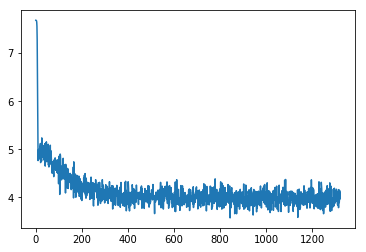

In [39]:
plt.plot(loss_lst)
plt.show()